In [15]:
import pandas as pd
import numpy as np
from scipy.stats import ortho_group
np.random.seed(seed=0)
x = ortho_group.rvs(6)

In [16]:
std_list = [1.5, 2.0, 1.5, 2.5, 1.7, 2.2]
fdf = pd.DataFrame()
for i in range(6):
    fdf[i] = np.random.normal(loc=0.0, scale=std_list[i], size=200000)

In [17]:
x[0]

array([ 0.47669462,  0.15964814, -0.47766656,  0.55284255, -0.13930486,
        0.44053222])

In [18]:
x[1]

array([ 0.10813329, -0.8838343 ,  0.06718921,  0.39309219,  0.13141423,
       -0.1756091 ])

In [19]:
fdf["group"] = 0.9 / (1.0 + np.exp(-np.matmul(fdf.values, x[0].T) + 5.0)) + 0.1 / (1.0 + np.exp(-np.matmul(fdf.values, x[1].T) + 6.0))

In [20]:
fdf["prob"] = np.random.uniform(low=0.0, high=1.0, size=200000)

In [21]:
fdf["label"] = fdf["group"] > fdf["prob"]

In [22]:
fdf["label"] = fdf["label"] * 1

In [23]:
fdf.label.value_counts()

0    193807
1      6193
Name: label, dtype: int64

In [24]:
cdf = fdf.copy()

In [25]:
Y = cdf.label.values
X = cdf.drop(["prob", "label", "group"], axis=1).values

In [26]:
X

array([[ 0.98042789, -2.6599224 , -0.83970261, -2.57846232,  1.63102901,
         1.59680702],
       [ 1.2966543 ,  2.77730202, -1.56281536,  1.36191519,  0.05851903,
        -1.14529369],
       [-1.11324753, -0.49798981, -1.41736499, -3.64590948, -1.74408025,
        -1.02271377],
       ...,
       [ 0.30299166, -0.01513392, -3.76087816, -0.14516751,  0.5472197 ,
        -0.88503424],
       [ 3.04884549,  1.75243167,  1.27937792,  0.27073633,  1.28851553,
         2.2701542 ],
       [-1.57838013, -0.60305905,  0.8499289 ,  3.59296108,  0.56226344,
         0.36216961]])

In [239]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data

torch.manual_seed(0)

In [240]:
class SubNet(torch.nn.Module):
    def __init__(self):
        super(SubNet, self).__init__()
        self.input = torch.nn.Linear(1, 6)
        self.hidden1 = torch.nn.Linear(6, 4)
        self.hidden2 = torch.nn.Linear(4, 2)
        self.output = torch.nn.Linear(2, 1)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = torch.sigmoid(self.output(x))
        return x

In [241]:
class FrontProcessing(torch.nn.Module):
    def __init__(self, sub_num, projection_num):
        super(FrontProcessing, self).__init__()
        self.weight = torch.nn.Parameter(torch.zeros(sub_num, projection_num))
        self.weightT = torch.transpose(self.weight, 0, 1)
        torch.nn.init.orthogonal_(self.weightT)
        self.weight.data.copy_(torch.transpose(self.weightT, 0, 1))
        
        self.bias = torch.nn.Parameter(torch.zeros(projection_num, 1))
        
    def forward(self, x):
        x = torch.mm(torch.transpose(self.weight, 0, 1), torch.transpose(x, 0, 1)) + self.bias
        return x
        

In [242]:
class Net(torch.nn.Module):
    def __init__(self, sub_num, projection_num, FrontProcessing, Subnet):
        super(Net, self).__init__()
        self.projection_number = projection_num
        self.frontprocessing = FrontProcessing(sub_num, projection_num)
        self.sub_networks = [SubNet() for _ in range(projection_num)]
        self.output_layer = [torch.nn.Parameter(torch.zeros(1)) for _ in range(projection_num)]
        
        if projection_num < 2:
            raise ValueError("projection number must be larger than or equal to 2")
            
        if projection_num >= sub_num:
            raise ValueError("subjects number must larger than projection number, no need to project to higher dimension")
        
        torch.nn.init.uniform_(self.output_layer[0], 0, 1)
        layer_sum = float(self.output_layer[0].data.numpy())
        
        for i in range(1, projection_num - 1):
            torch.nn.init.uniform_(self.output_layer[i], 0.0, 1.0 - layer_sum)
            layer_sum += float(self.output_layer[i])
            
        self.output_layer[-1].data = torch.tensor([1.0 - layer_sum])
        self.output = torch.cat(tuple(self.output_layer)).view(-1, 1)
            
    def forward(self, x):
        x = self.frontprocessing(x)
        intermediate_result = self.sub_networks[0](x[0].view(-1, 1))
        for i in range(1, self.projection_number):
            intermediate_result = torch.cat((intermediate_result, self.sub_networks[i](x[i].view(-1, 1))), 1)
        return torch.mm(intermediate_result, self.output)

In [243]:
net = Net(6, 3, FrontProcessing, SubNet)

In [244]:
torch.transpose(net(X_torch.float()), 0, 1)

tensor([[0.4590, 0.4583, 0.4611,  ..., 0.4595, 0.4656, 0.4557]],
       grad_fn=<TransposeBackward0>)

In [245]:
print(net)

Net(
  (frontprocessing): FrontProcessing()
)


In [65]:
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.weight = torch.nn.Parameter(torch.zeros(6, 2))
#         self.weightT = torch.transpose(self.weight, 0, 1)
#         torch.nn.init.orthogonal_(self.weightT)
#         self.weight.data.copy_(torch.transpose(self.weightT, 0, 1))
        
#         self.bias = torch.nn.Parameter(torch.zeros(2, 1))
        
#         self.oweight = torch.nn.Parameter(torch.zeros(1))
        
#     def forward(self, x):
#         x = torch.mm(torch.transpose(self.weight, 0, 1), torch.transpose(x, 0, 1)) + self.bias
#         x = torch.sigmoid(x)
#         self.oweight_comb = torch.cat((self.oweight, 1.0 - self.oweight)).unsqueeze(0)
#         x = torch.mm(torch.transpose(x, 0, 1), torch.transpose(self.oweight_comb, 0, 1))
#         return x
        

In [227]:
X_torch = torch.tensor(X)
Y_torch = torch.tensor(Y)

In [228]:
torch_data_set = Data.TensorDataset(X_torch, Y_torch)
loader = Data.DataLoader(
    dataset=torch_data_set,
    batch_size=1000,
    shuffle=True
)

In [232]:
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [233]:
list(net.parameters())

[Parameter containing:
 tensor([[ 0.5676,  0.6286, -0.2789],
         [ 0.3724, -0.2194,  0.4450],
         [-0.3254, -0.1829, -0.4730],
         [ 0.1092,  0.1073, -0.5919],
         [-0.4436,  0.7125,  0.3629],
         [ 0.4739, -0.0637,  0.1357]], requires_grad=True),
 Parameter containing:
 tensor([[0.],
         [0.],
         [0.]], requires_grad=True)]

In [70]:
net(X_torch.float())

tensor([[0.3794],
        [0.8140],
        [0.8274],
        ...,
        [0.6123],
        [0.8250],
        [0.0905]], grad_fn=<MmBackward>)

In [71]:
for epoch in range(600):
    for step, (X_train, Y_train) in enumerate(loader):
        optimizer.zero_grad()
        X_train = X_train.requires_grad_(True)

        logistic_regression_result = net(X_train.float())
        loss = F.binary_cross_entropy(logistic_regression_result, Y_train.unsqueeze(1).float())
        
        loss.backward()
        weight_partial = net.weight.grad
        oweight_partial = net.oweight.grad
        
        with torch.no_grad():
            matA = torch.mm(weight_partial, torch.transpose(net.weight, 0, 1)) - torch.mm(net.weight, torch.transpose(weight_partial, 0, 1))
            update_matrix = torch.mm(torch.inverse(torch.eye(6) + matA * 0.00001 / 2.0), (torch.eye(6) - matA * 0.00001 / 2.0))
            updated_weight = torch.mm(update_matrix, net.weight)
            oweight_new = net.oweight - (lr / 10.0) * oweight_partial
        optimizer.step()
        net.weight.data = updated_weight
        net.oweight.data = oweight_new
        net.oweight.data.clamp_(0, 1)
        
        
    with torch.no_grad():
        loss_all = F.binary_cross_entropy(net(X_torch.float()), Y_torch.unsqueeze(1).float())
        print('Epoch: ', epoch,'| loss: ', loss_all.data.numpy())
        print(net.weight)
        print(net.bias)
        print(net.oweight)
        print("******************************************")

Epoch:  0 | loss:  0.3566891
Parameter containing:
tensor([[ 0.4768,  0.0795],
        [-0.0925,  0.7278],
        [-0.6734, -0.2340],
        [ 0.1803, -0.4127],
        [-0.3299, -0.3092],
        [-0.4114,  0.3786]], requires_grad=True)
Parameter containing:
tensor([[-1.8210],
        [-0.9568]], requires_grad=True)
Parameter containing:
tensor([0.8062], requires_grad=True)
******************************************
Epoch:  1 | loss:  0.19043568
Parameter containing:
tensor([[ 0.4942,  0.0700],
        [-0.0929,  0.7299],
        [-0.6941, -0.2210],
        [ 0.1953, -0.4050],
        [-0.3251, -0.3011],
        [-0.3487,  0.3984]], requires_grad=True)
Parameter containing:
tensor([[-3.1027],
        [-1.0642]], requires_grad=True)
Parameter containing:
tensor([0.9838], requires_grad=True)
******************************************
Epoch:  2 | loss:  0.1457333
Parameter containing:
tensor([[ 0.5202,  0.0460],
        [-0.0850,  0.7340],
        [-0.7229, -0.1879],
        [ 0.2218, 

Epoch:  20 | loss:  0.12597041
Parameter containing:
tensor([[-0.0262, -0.3846],
        [ 0.0918,  0.7325],
        [ 0.2594,  0.3620],
        [ 0.7693, -0.3394],
        [ 0.1982, -0.1457],
        [ 0.5411,  0.2195]], requires_grad=True)
Parameter containing:
tensor([[-5.6051],
        [-1.9453]], requires_grad=True)
Parameter containing:
tensor([0.9947], requires_grad=True)
******************************************
Epoch:  21 | loss:  0.12327446
Parameter containing:
tensor([[ 0.0178, -0.3870],
        [ 0.0788,  0.7400],
        [ 0.2106,  0.3716],
        [ 0.8080, -0.2884],
        [ 0.1714, -0.1430],
        [ 0.5169,  0.2472]], requires_grad=True)
Parameter containing:
tensor([[-5.6710],
        [-1.8544]], requires_grad=True)
Parameter containing:
tensor([0.9778], requires_grad=True)
******************************************
Epoch:  22 | loss:  0.12105189
Parameter containing:
tensor([[ 0.0666, -0.3869],
        [ 0.0652,  0.7462],
        [ 0.1548,  0.3783],
        [ 0.8

Epoch:  40 | loss:  0.10312807
Parameter containing:
tensor([[ 0.5792, -0.3216],
        [ 0.0915,  0.5108],
        [-0.6282,  0.3370],
        [ 0.3209,  0.5373],
        [-0.2186, -0.0942],
        [ 0.3337,  0.4741]], requires_grad=True)
Parameter containing:
tensor([[-4.6476],
        [-5.4572]], requires_grad=True)
Parameter containing:
tensor([0.8194], requires_grad=True)
******************************************
Epoch:  41 | loss:  0.102855995
Parameter containing:
tensor([[ 0.5725, -0.3315],
        [ 0.1017,  0.4758],
        [-0.6267,  0.3496],
        [ 0.3272,  0.5669],
        [-0.2153, -0.0798],
        [ 0.3411,  0.4627]], requires_grad=True)
Parameter containing:
tensor([[-4.6935],
        [-5.5397]], requires_grad=True)
Parameter containing:
tensor([0.8064], requires_grad=True)
******************************************
Epoch:  42 | loss:  0.10244246
Parameter containing:
tensor([[ 0.5653, -0.3419],
        [ 0.1103,  0.4386],
        [-0.6234,  0.3631],
        [ 0.

Epoch:  60 | loss:  0.09909621
Parameter containing:
tensor([[ 0.4554, -0.3650],
        [ 0.1860, -0.2939],
        [-0.4775,  0.4356],
        [ 0.5503,  0.7509],
        [-0.1480,  0.1436],
        [ 0.4538,  0.0813]], requires_grad=True)
Parameter containing:
tensor([[-5.0401],
        [-4.8011]], requires_grad=True)
Parameter containing:
tensor([0.9595], requires_grad=True)
******************************************
Epoch:  61 | loss:  0.0990499
Parameter containing:
tensor([[ 0.4533, -0.3523],
        [ 0.1887, -0.3273],
        [-0.4728,  0.4231],
        [ 0.5515,  0.7509],
        [-0.1486,  0.1488],
        [ 0.4581,  0.0645]], requires_grad=True)
Parameter containing:
tensor([[-5.1039],
        [-4.8690]], requires_grad=True)
Parameter containing:
tensor([0.9560], requires_grad=True)
******************************************
Epoch:  62 | loss:  0.099064104
Parameter containing:
tensor([[ 0.4516, -0.3387],
        [ 0.1910, -0.3593],
        [-0.4689,  0.4096],
        [ 0.5

Epoch:  80 | loss:  0.09865559
Parameter containing:
tensor([[ 0.4527, -0.0971],
        [ 0.1838, -0.7105],
        [-0.4614,  0.1664],
        [ 0.5544,  0.6328],
        [-0.1611,  0.1900],
        [ 0.4644, -0.1484]], requires_grad=True)
Parameter containing:
tensor([[-5.0660],
        [-5.7862]], requires_grad=True)
Parameter containing:
tensor([0.9190], requires_grad=True)
******************************************
Epoch:  81 | loss:  0.09864956
Parameter containing:
tensor([[ 0.4532, -0.0875],
        [ 0.1821, -0.7205],
        [-0.4624,  0.1573],
        [ 0.5550,  0.6234],
        [-0.1608,  0.1906],
        [ 0.4631, -0.1549]], requires_grad=True)
Parameter containing:
tensor([[-5.0975],
        [-5.6571]], requires_grad=True)
Parameter containing:
tensor([0.9282], requires_grad=True)
******************************************
Epoch:  82 | loss:  0.09862681
Parameter containing:
tensor([[ 0.4538, -0.0783],
        [ 0.1805, -0.7298],
        [-0.4634,  0.1487],
        [ 0.5

Epoch:  100 | loss:  0.09851224
Parameter containing:
tensor([[ 0.4589,  0.0357],
        [ 0.1613, -0.8232],
        [-0.4763,  0.0585],
        [ 0.5581,  0.4847],
        [-0.1513,  0.1912],
        [ 0.4504, -0.2160]], requires_grad=True)
Parameter containing:
tensor([[-5.0086],
        [-6.0757]], requires_grad=True)
Parameter containing:
tensor([0.9030], requires_grad=True)
******************************************
Epoch:  101 | loss:  0.09852112
Parameter containing:
tensor([[ 0.4591,  0.0400],
        [ 0.1609, -0.8259],
        [-0.4767,  0.0561],
        [ 0.5581,  0.4797],
        [-0.1509,  0.1908],
        [ 0.4500, -0.2170]], requires_grad=True)
Parameter containing:
tensor([[-4.9710],
        [-6.1937]], requires_grad=True)
Parameter containing:
tensor([0.8979], requires_grad=True)
******************************************
Epoch:  102 | loss:  0.09851681
Parameter containing:
tensor([[ 0.4593,  0.0441],
        [ 0.1604, -0.8284],
        [-0.4770,  0.0538],
        [ 

Epoch:  120 | loss:  0.09850741
Parameter containing:
tensor([[ 0.4625,  0.0959],
        [ 0.1554, -0.8555],
        [-0.4815,  0.0372],
        [ 0.5564,  0.4180],
        [-0.1495,  0.1866],
        [ 0.4459, -0.2201]], requires_grad=True)
Parameter containing:
tensor([[-5.0126],
        [-6.2528]], requires_grad=True)
Parameter containing:
tensor([0.8897], requires_grad=True)
******************************************
Epoch:  121 | loss:  0.09852548
Parameter containing:
tensor([[ 0.4626,  0.0979],
        [ 0.1554, -0.8564],
        [-0.4816,  0.0372],
        [ 0.5563,  0.4161],
        [-0.1495,  0.1865],
        [ 0.4458, -0.2196]], requires_grad=True)
Parameter containing:
tensor([[-5.0314],
        [-6.2960]], requires_grad=True)
Parameter containing:
tensor([0.8891], requires_grad=True)
******************************************
Epoch:  122 | loss:  0.098497644
Parameter containing:
tensor([[ 0.4626,  0.0997],
        [ 0.1552, -0.8572],
        [-0.4818,  0.0374],
        [

Epoch:  140 | loss:  0.09849593
Parameter containing:
tensor([[ 0.4639,  0.1247],
        [ 0.1543, -0.8654],
        [-0.4835,  0.0478],
        [ 0.5553,  0.3945],
        [-0.1497,  0.1867],
        [ 0.4440, -0.2078]], requires_grad=True)
Parameter containing:
tensor([[-4.9975],
        [-6.2694]], requires_grad=True)
Parameter containing:
tensor([0.8969], requires_grad=True)
******************************************
Epoch:  141 | loss:  0.09849158
Parameter containing:
tensor([[ 0.4639,  0.1257],
        [ 0.1543, -0.8656],
        [-0.4835,  0.0488],
        [ 0.5553,  0.3939],
        [-0.1497,  0.1868],
        [ 0.4440, -0.2071]], requires_grad=True)
Parameter containing:
tensor([[-4.9888],
        [-6.2084]], requires_grad=True)
Parameter containing:
tensor([0.8945], requires_grad=True)
******************************************
Epoch:  142 | loss:  0.09849167
Parameter containing:
tensor([[ 0.4639,  0.1266],
        [ 0.1543, -0.8659],
        [-0.4836,  0.0497],
        [ 

Epoch:  160 | loss:  0.09849544
Parameter containing:
tensor([[ 0.4643,  0.1400],
        [ 0.1539, -0.8667],
        [-0.4846,  0.0691],
        [ 0.5545,  0.3896],
        [-0.1498,  0.1889],
        [ 0.4435, -0.1935]], requires_grad=True)
Parameter containing:
tensor([[-4.9503],
        [-6.1976]], requires_grad=True)
Parameter containing:
tensor([0.8903], requires_grad=True)
******************************************
Epoch:  161 | loss:  0.09848716
Parameter containing:
tensor([[ 0.4642,  0.1406],
        [ 0.1539, -0.8667],
        [-0.4846,  0.0702],
        [ 0.5545,  0.3896],
        [-0.1498,  0.1890],
        [ 0.4436, -0.1928]], requires_grad=True)
Parameter containing:
tensor([[-4.9602],
        [-6.2613]], requires_grad=True)
Parameter containing:
tensor([0.8856], requires_grad=True)
******************************************
Epoch:  162 | loss:  0.09851586
Parameter containing:
tensor([[ 0.4642,  0.1412],
        [ 0.1540, -0.8666],
        [-0.4846,  0.0713],
        [ 

Epoch:  180 | loss:  0.09850156
Parameter containing:
tensor([[ 0.4640,  0.1497],
        [ 0.1540, -0.8641],
        [-0.4856,  0.0918],
        [ 0.5538,  0.3920],
        [-0.1499,  0.1914],
        [ 0.4435, -0.1809]], requires_grad=True)
Parameter containing:
tensor([[-4.9384],
        [-6.2739]], requires_grad=True)
Parameter containing:
tensor([0.8939], requires_grad=True)
******************************************
Epoch:  181 | loss:  0.09851219
Parameter containing:
tensor([[ 0.4640,  0.1501],
        [ 0.1541, -0.8639],
        [-0.4856,  0.0929],
        [ 0.5538,  0.3922],
        [-0.1500,  0.1915],
        [ 0.4435, -0.1803]], requires_grad=True)
Parameter containing:
tensor([[-4.9427],
        [-6.0774]], requires_grad=True)
Parameter containing:
tensor([0.9032], requires_grad=True)
******************************************
Epoch:  182 | loss:  0.0984878
Parameter containing:
tensor([[ 0.4640,  0.1505],
        [ 0.1541, -0.8637],
        [-0.4855,  0.0940],
        [ 0

Epoch:  200 | loss:  0.09848123
Parameter containing:
tensor([[ 0.4643,  0.1567],
        [ 0.1543, -0.8599],
        [-0.4856,  0.1128],
        [ 0.5536,  0.3964],
        [-0.1499,  0.1933],
        [ 0.4433, -0.1709]], requires_grad=True)
Parameter containing:
tensor([[-4.9671],
        [-6.1988]], requires_grad=True)
Parameter containing:
tensor([0.8950], requires_grad=True)
******************************************
Epoch:  201 | loss:  0.09848281
Parameter containing:
tensor([[ 0.4642,  0.1570],
        [ 0.1544, -0.8597],
        [-0.4855,  0.1138],
        [ 0.5537,  0.3967],
        [-0.1499,  0.1934],
        [ 0.4434, -0.1704]], requires_grad=True)
Parameter containing:
tensor([[-5.0007],
        [-6.1840]], requires_grad=True)
Parameter containing:
tensor([0.8948], requires_grad=True)
******************************************
Epoch:  202 | loss:  0.098544255
Parameter containing:
tensor([[ 0.4641,  0.1573],
        [ 0.1544, -0.8595],
        [-0.4857,  0.1148],
        [

Epoch:  220 | loss:  0.09848868
Parameter containing:
tensor([[ 0.4641,  0.1623],
        [ 0.1544, -0.8554],
        [-0.4858,  0.1310],
        [ 0.5535,  0.4010],
        [-0.1501,  0.1947],
        [ 0.4433, -0.1631]], requires_grad=True)
Parameter containing:
tensor([[-4.9488],
        [-6.1045]], requires_grad=True)
Parameter containing:
tensor([0.8903], requires_grad=True)
******************************************
Epoch:  221 | loss:  0.098476276
Parameter containing:
tensor([[ 0.4641,  0.1625],
        [ 0.1545, -0.8552],
        [-0.4858,  0.1318],
        [ 0.5536,  0.4012],
        [-0.1501,  0.1947],
        [ 0.4432, -0.1628]], requires_grad=True)
Parameter containing:
tensor([[-4.9762],
        [-6.2308]], requires_grad=True)
Parameter containing:
tensor([0.8901], requires_grad=True)
******************************************
Epoch:  222 | loss:  0.09847622
Parameter containing:
tensor([[ 0.4641,  0.1628],
        [ 0.1545, -0.8549],
        [-0.4858,  0.1326],
        [

Epoch:  240 | loss:  0.09847663
Parameter containing:
tensor([[ 0.4640,  0.1670],
        [ 0.1545, -0.8512],
        [-0.4861,  0.1461],
        [ 0.5535,  0.4048],
        [-0.1501,  0.1953],
        [ 0.4431, -0.1572]], requires_grad=True)
Parameter containing:
tensor([[-4.9679],
        [-6.1963]], requires_grad=True)
Parameter containing:
tensor([0.8930], requires_grad=True)
******************************************
Epoch:  241 | loss:  0.098483466
Parameter containing:
tensor([[ 0.4639,  0.1673],
        [ 0.1546, -0.8510],
        [-0.4861,  0.1468],
        [ 0.5535,  0.4049],
        [-0.1501,  0.1953],
        [ 0.4432, -0.1569]], requires_grad=True)
Parameter containing:
tensor([[-4.9795],
        [-6.1342]], requires_grad=True)
Parameter containing:
tensor([0.9061], requires_grad=True)
******************************************
Epoch:  242 | loss:  0.098488115
Parameter containing:
tensor([[ 0.4639,  0.1675],
        [ 0.1547, -0.8508],
        [-0.4861,  0.1474],
        

Epoch:  260 | loss:  0.0984737
Parameter containing:
tensor([[ 0.4642,  0.1712],
        [ 0.1546, -0.8476],
        [-0.4860,  0.1583],
        [ 0.5532,  0.4077],
        [-0.1501,  0.1953],
        [ 0.4433, -0.1527]], requires_grad=True)
Parameter containing:
tensor([[-4.9870],
        [-6.1003]], requires_grad=True)
Parameter containing:
tensor([0.8974], requires_grad=True)
******************************************
Epoch:  261 | loss:  0.098477334
Parameter containing:
tensor([[ 0.4642,  0.1715],
        [ 0.1547, -0.8474],
        [-0.4861,  0.1588],
        [ 0.5532,  0.4079],
        [-0.1501,  0.1953],
        [ 0.4433, -0.1525]], requires_grad=True)
Parameter containing:
tensor([[-4.9734],
        [-6.0268]], requires_grad=True)
Parameter containing:
tensor([0.8973], requires_grad=True)
******************************************
Epoch:  262 | loss:  0.09851492
Parameter containing:
tensor([[ 0.4642,  0.1717],
        [ 0.1547, -0.8472],
        [-0.4861,  0.1594],
        [ 

Epoch:  280 | loss:  0.098484024
Parameter containing:
tensor([[ 0.4639,  0.1752],
        [ 0.1549, -0.8445],
        [-0.4862,  0.1681],
        [ 0.5532,  0.4100],
        [-0.1500,  0.1950],
        [ 0.4434, -0.1495]], requires_grad=True)
Parameter containing:
tensor([[-4.9508],
        [-6.1313]], requires_grad=True)
Parameter containing:
tensor([0.8936], requires_grad=True)
******************************************
Epoch:  281 | loss:  0.09847832
Parameter containing:
tensor([[ 0.4638,  0.1754],
        [ 0.1549, -0.8443],
        [-0.4862,  0.1685],
        [ 0.5532,  0.4100],
        [-0.1501,  0.1949],
        [ 0.4434, -0.1494]], requires_grad=True)
Parameter containing:
tensor([[-4.9669],
        [-6.0875]], requires_grad=True)
Parameter containing:
tensor([0.8961], requires_grad=True)
******************************************
Epoch:  282 | loss:  0.09849192
Parameter containing:
tensor([[ 0.4637,  0.1756],
        [ 0.1549, -0.8442],
        [-0.4863,  0.1690],
        [

Epoch:  300 | loss:  0.098475724
Parameter containing:
tensor([[ 0.4640,  0.1787],
        [ 0.1551, -0.8419],
        [-0.4863,  0.1759],
        [ 0.5531,  0.4115],
        [-0.1500,  0.1945],
        [ 0.4433, -0.1471]], requires_grad=True)
Parameter containing:
tensor([[-4.9980],
        [-6.1070]], requires_grad=True)
Parameter containing:
tensor([0.8942], requires_grad=True)
******************************************
Epoch:  301 | loss:  0.09848868
Parameter containing:
tensor([[ 0.4639,  0.1788],
        [ 0.1551, -0.8418],
        [-0.4863,  0.1762],
        [ 0.5531,  0.4116],
        [-0.1500,  0.1945],
        [ 0.4433, -0.1470]], requires_grad=True)
Parameter containing:
tensor([[-4.9477],
        [-6.0948]], requires_grad=True)
Parameter containing:
tensor([0.8956], requires_grad=True)
******************************************
Epoch:  302 | loss:  0.09849814
Parameter containing:
tensor([[ 0.4639,  0.1790],
        [ 0.1551, -0.8417],
        [-0.4864,  0.1766],
        [

Epoch:  320 | loss:  0.09847522
Parameter containing:
tensor([[ 0.4640,  0.1815],
        [ 0.1550, -0.8399],
        [-0.4864,  0.1822],
        [ 0.5530,  0.4125],
        [-0.1500,  0.1939],
        [ 0.4432, -0.1454]], requires_grad=True)
Parameter containing:
tensor([[-4.9864],
        [-6.1303]], requires_grad=True)
Parameter containing:
tensor([0.8890], requires_grad=True)
******************************************
Epoch:  321 | loss:  0.0984773
Parameter containing:
tensor([[ 0.4640,  0.1816],
        [ 0.1550, -0.8398],
        [-0.4862,  0.1825],
        [ 0.5531,  0.4125],
        [-0.1500,  0.1939],
        [ 0.4432, -0.1454]], requires_grad=True)
Parameter containing:
tensor([[-5.0025],
        [-6.1267]], requires_grad=True)
Parameter containing:
tensor([0.8986], requires_grad=True)
******************************************
Epoch:  322 | loss:  0.09847502
Parameter containing:
tensor([[ 0.4641,  0.1817],
        [ 0.1549, -0.8398],
        [-0.4863,  0.1828],
        [ 0

Epoch:  340 | loss:  0.098494865
Parameter containing:
tensor([[ 0.4637,  0.1839],
        [ 0.1550, -0.8383],
        [-0.4863,  0.1870],
        [ 0.5532,  0.4131],
        [-0.1499,  0.1934],
        [ 0.4434, -0.1442]], requires_grad=True)
Parameter containing:
tensor([[-4.9435],
        [-6.0261]], requires_grad=True)
Parameter containing:
tensor([0.8950], requires_grad=True)
******************************************
Epoch:  341 | loss:  0.09847265
Parameter containing:
tensor([[ 0.4638,  0.1841],
        [ 0.1551, -0.8383],
        [-0.4864,  0.1872],
        [ 0.5531,  0.4132],
        [-0.1499,  0.1933],
        [ 0.4433, -0.1441]], requires_grad=True)
Parameter containing:
tensor([[-4.9882],
        [-6.0479]], requires_grad=True)
Parameter containing:
tensor([0.8947], requires_grad=True)
******************************************
Epoch:  342 | loss:  0.09848074
Parameter containing:
tensor([[ 0.4638,  0.1842],
        [ 0.1551, -0.8382],
        [-0.4863,  0.1874],
        [

KeyboardInterrupt: 

In [72]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.4638,  0.1859],
        [ 0.1552, -0.8372],
        [-0.4864,  0.1903],
        [ 0.5530,  0.4136],
        [-0.1500,  0.1929],
        [ 0.4433, -0.1432]], requires_grad=True)
Parameter containing:
tensor([[-4.9612],
        [-6.1496]], requires_grad=True)
Parameter containing:
tensor([0.8962], requires_grad=True)


In [73]:
print(x[0])
print(x[1])

[ 0.47669462  0.15964814 -0.47766656  0.55284255 -0.13930486  0.44053222]
[ 0.10813329 -0.8838343   0.06718921  0.39309219  0.13141423 -0.1756091 ]


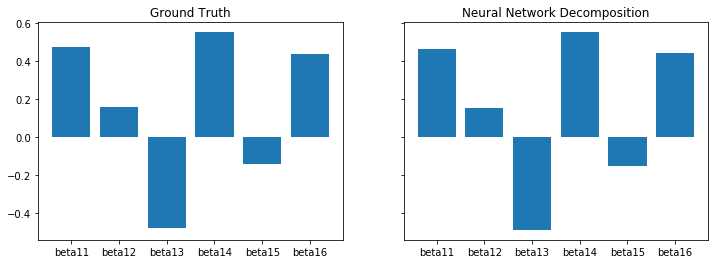

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
names = ["beta11", "beta12", "beta13", "beta14", "beta15", "beta16"]
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axs[0].set_title("Ground Truth")
axs[0].bar(x=names, height=x[0])
axs[1].set_title("Neural Network Decomposition")
axs[1].bar(x=names, height=net.weight[:, 0].data.numpy())
plt.show()

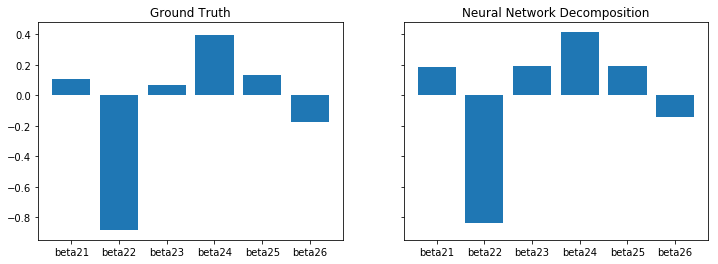

In [76]:
names = ["beta21", "beta22", "beta23", "beta24", "beta25", "beta26"]
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axs[0].set_title("Ground Truth")
axs[0].bar(x=names, height=x[1])
axs[1].set_title("Neural Network Decomposition")
axs[1].bar(x=names, height=net.weight[:, 1].data.numpy())
plt.show()